In [ ]:
import yfinance as yf
import os

META = yf.Ticker("META")
for key, value in META.info.items():
    print(key, ":", value)

TSLA = yf.Ticker("TSLA")
for key, value in TSLA.info.items():
    print(key, ":", value)

LMT = yf.Ticker("LMT")
for key, value in LMT.info.items():
    print(key, ":", value)
AAPL = yf.Ticker("AAPL")
for key, value in AAPL.info.items():
    print(key, ":", value)
MSFT = yf.Ticker("MSFT")
for key, value in MSFT.info.items():
    print(key, ":", value)

address1 : 1 Meta Way
city : Menlo Park
state : CA
zip : 94025
country : United States
phone : 650 543 4800
website : https://investor.fb.com
industry : Internet Content & Information
industryKey : internet-content-information
industryDisp : Internet Content & Information
sector : Communication Services
sectorKey : communication-services
sectorDisp : Communication Services
longBusinessSummary : Meta Platforms, Inc. engages in the development of products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, and wearables worldwide. It operates in two segments, Family of Apps and Reality Labs. The Family of Apps segment offers Facebook, which enables people to share, discuss, discover, and connect with interests; Instagram, a community for sharing photos, videos, and private messages, as well as feed, stories, reels, video, live, and shops; Messenger, a messaging application for people to connect with friends

In [ ]:
import yfinance as yf
import psycopg2
import pandas as pd

# Stažení dat z Yahoo Finance
tickers = ["META", "TSLA", "LMT", "AAPL", "MSFT"]
df_list = []

for ticker in tickers:
    df = yf.download(ticker, start="2020-02-08")
    df["ticker"] = ticker  # Přidáme sloupec s názvem akcie
    df_list.append(df)

#  Spojení všech dat do jednoho DataFrame
df_all = pd.concat(df_list)
df_all.reset_index(inplace=True)  # Převod indexu 'Date' na sloupec

#  Ověření dat před odesláním
print(df_all.head())  # Kontrola stažených dat

#  Připojení k PostgreSQL
try:
    conn = psycopg2.connect(
        host="localhost",
        dbname="akcie",
        user="postgres",
        password="neni"
    )
    print(" Připojeno k databázi")

    cursor = conn.cursor()

    #  Opravená tabulka `stock_prices`
    create_table_query = """
    CREATE TABLE IF NOT EXISTS stock_prices (
        ticker TEXT,
        date DATE,
        open FLOAT,
        high FLOAT,
        low FLOAT,
        close FLOAT,
        adj_close FLOAT,
        volume BIGINT,
        PRIMARY KEY (ticker, date)  -- Kombinace ticker a date bude unikátní
    );
    """
    cursor.execute(create_table_query)
    conn.commit()

    #  Vkládání dat do správné tabulky `stock_prices`
    insert_query = """
    INSERT INTO stock_prices (ticker, date, open, high, low, close, adj_close, volume)
    SELECT %s, %s, %s, %s, %s, %s, %s, %s
    WHERE NOT EXISTS (
        SELECT 1 FROM stock_prices WHERE ticker = %s AND date = %s
    )
    """

    for _, row in df_all.iterrows():
        cursor.execute(insert_query, (
            row["ticker"], row["Date"], row["Open"], row["High"], row["Low"], 
            row["Close"], row["Adj Close"], row["Volume"],
            row["ticker"], row["Date"]
        ))

    conn.commit()  #  Uložení změn
    print(" Data úspěšně uložena do PostgreSQL")

    cursor.close()
    conn.close()

except Exception as e:
    print(" Chyba připojení nebo zápisu do databáze:", e)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
        Date        Open        High         Low       Close   Adj Close  \
0 2020-02-10  211.520004  213.800003  210.660004  213.059998  212.249222   
1 2020-02-11  210.190002  210.860001  206.509995  207.190002  206.401566   
2 2020-02-12  207.850006  211.220001  207.399994  210.759995  209.957947   
3 2020-02-13  209.520004  214.330002  209.179993  213.139999  212.328918   
4 2020-02-14  214.000000  214.929993  212.649994  214.179993  213.364944   

     Volume ticker  
0  11856400   META  
1  25030800   META  
2  13813700   META  
3  15396600   META  
4  10741700   META  
 Připojeno k databázi
 Data úspěšně uložena do PostgreSQL


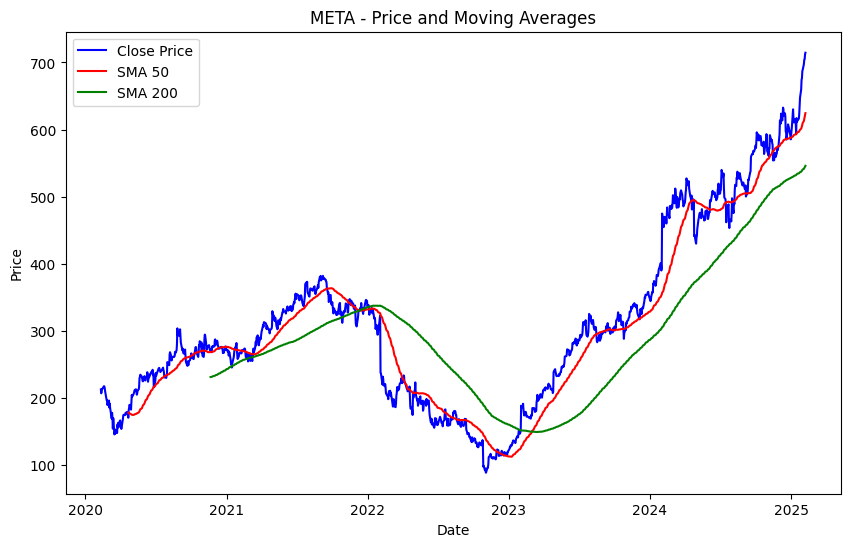

In [7]:
import matplotlib.pyplot as plt

# Vytvoření klouzavých průměrů
df_all['SMA_50'] = df_all.groupby('ticker')['Close'].rolling(window=50).mean().reset_index(0, drop=True)
df_all['SMA_200'] = df_all.groupby('ticker')['Close'].rolling(window=200).mean().reset_index(0, drop=True)
df_all['EMA_50'] = df_all.groupby('ticker')['Close'].ewm(span=50, adjust=False).mean().reset_index(0, drop=True)

# Grafy pro jednu akcii (např. META)
meta_data = df_all[df_all['ticker'] == 'META']

plt.figure(figsize=(10, 6))
plt.plot(meta_data['Date'], meta_data['Close'], label='Close Price', color='blue')
plt.plot(meta_data['Date'], meta_data['SMA_50'], label='SMA 50', color='red')
plt.plot(meta_data['Date'], meta_data['SMA_200'], label='SMA 200', color='green')
plt.title("META - Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [8]:
# Průměrná cena pro každý ticker
avg_price = df_all.groupby('ticker')['Close'].mean()
print("Průměrné ceny pro jednotlivé akcie:\n", avg_price)

# Výpočet volatility (standardní odchylka) pro každou akcii
volatility = df_all.groupby('ticker')['Close'].std()
print("\nVolatilita jednotlivých akcií:\n", volatility)

# Korelace mezi akciemi
correlation = df_all.pivot_table(values='Close', index='Date', columns='ticker').corr()
print("\nKorelace mezi akciemi:\n", correlation)


Průměrné ceny pro jednotlivé akcie:
 ticker
AAPL    157.262235
LMT     425.267430
META    310.071297
MSFT    299.571694
TSLA    220.752933
Name: Close, dtype: float64

Volatilita jednotlivých akcií:
 ticker
AAPL     41.518945
LMT      60.748338
META    133.480055
MSFT     80.075539
TSLA     83.534251
Name: Close, dtype: float64

Korelace mezi akciemi:
 ticker      AAPL       LMT      META      MSFT      TSLA
ticker                                                  
AAPL    1.000000  0.700015  0.706148  0.925332  0.671995
LMT     0.700015  1.000000  0.411922  0.619615  0.144004
META    0.706148  0.411922  1.000000  0.827505  0.356242
MSFT    0.925332  0.619615  0.827505  1.000000  0.517662
TSLA    0.671995  0.144004  0.356242  0.517662  1.000000


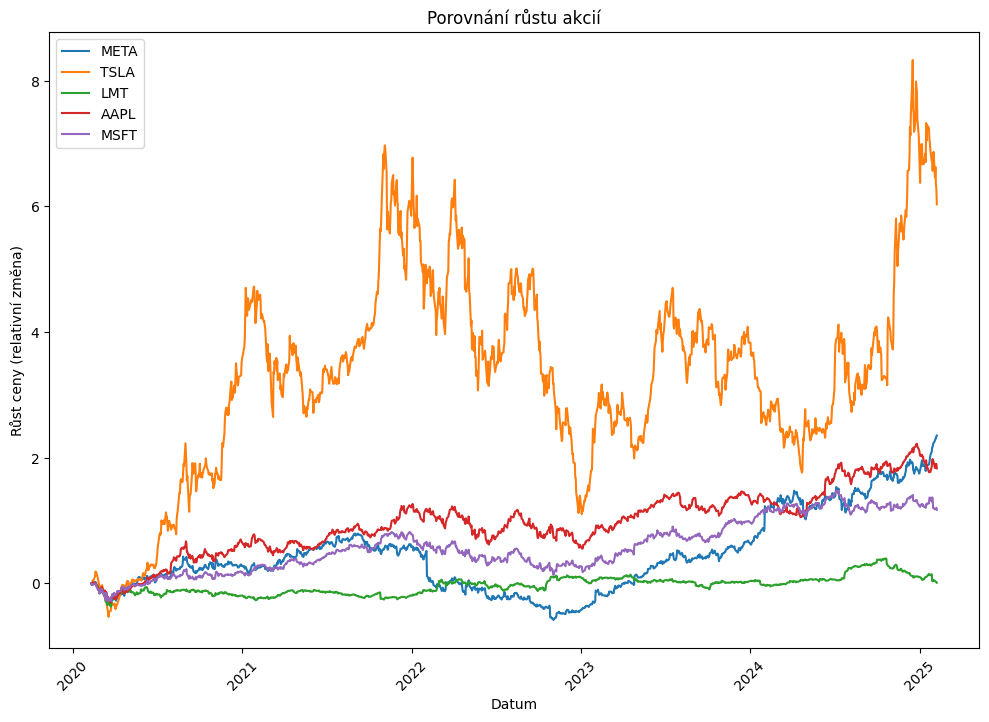

In [29]:
import matplotlib.pyplot as plt

# Ujistíme se, že sloupec 'Date' je typu datetime
df_all['Date'] = pd.to_datetime(df_all['Date'])

# Spojení všech akcií a výpočet růstu ceny (od začátku)
# Pro každou akcii spočítáme růst ceny od první dostupné hodnoty
df_all['Growth'] = df_all.groupby('ticker')['Close'].apply(lambda x: (x / x.iloc[0]) - 1).reset_index(level=0, drop=True)

# Plot pro porovnání růstu
plt.figure(figsize=(12, 8))

# Pro každý ticker vykreslíme graf růstu
for ticker in tickers:
    ticker_data = df_all[df_all['ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Growth'], label=ticker)

# Nastavení grafu
plt.title("Porovnání růstu akcií")
plt.xlabel("Datum")
plt.ylabel("Růst ceny (relativní změna)")
plt.legend()
plt.xticks(rotation=45)
plt.show()


Zpracovávám akcii: META
[*********************100%%**********************]  1 of 1 completed
META - Mean Squared Error (MSE): 12.410402063896223


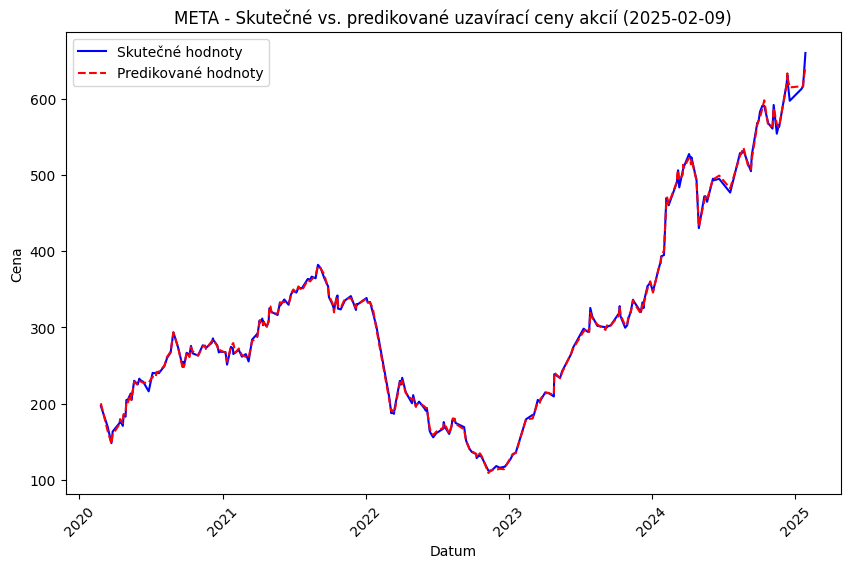

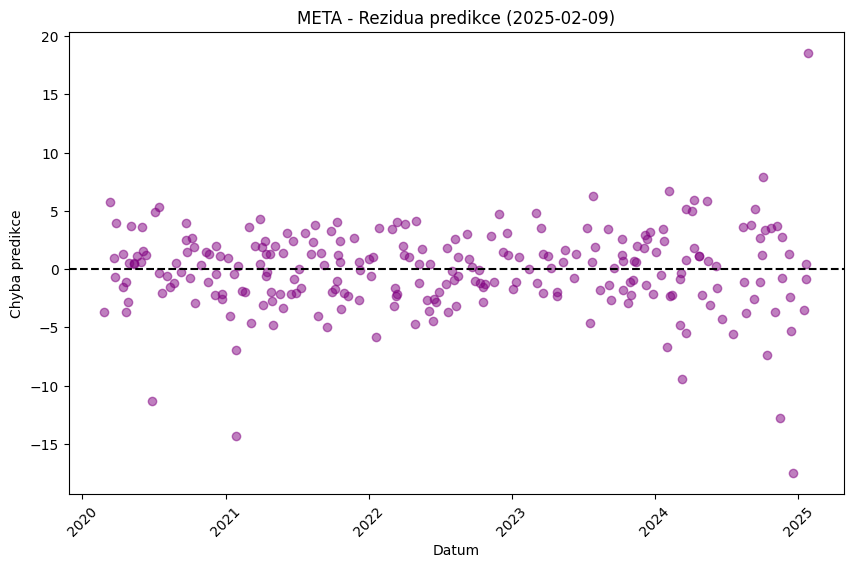

Zpracovávám akcii: TSLA
[*********************100%%**********************]  1 of 1 completed
TSLA - Mean Squared Error (MSE): 14.769787534364015


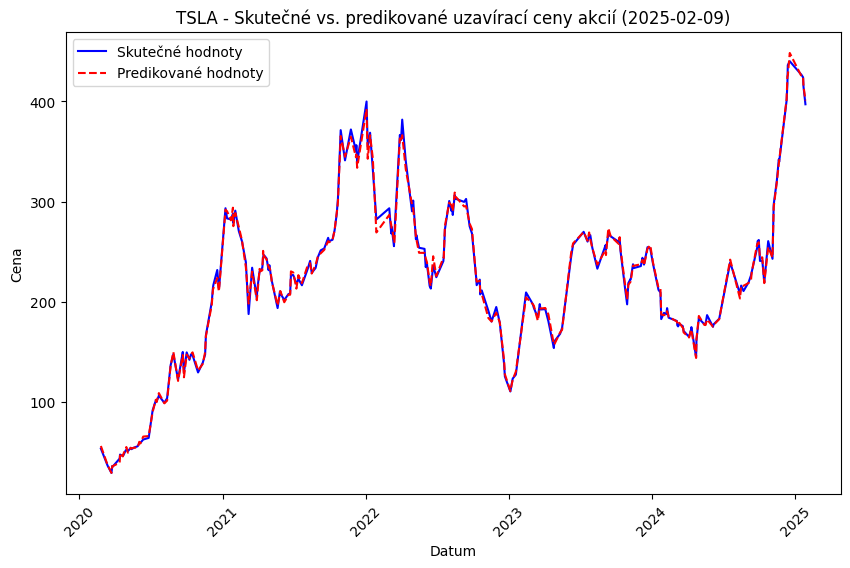

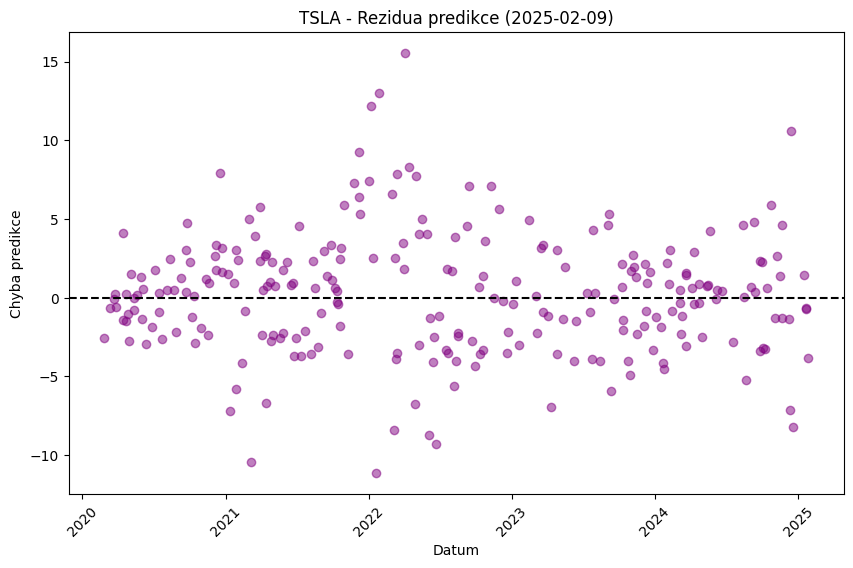

Zpracovávám akcii: LMT
[*********************100%%**********************]  1 of 1 completed
LMT - Mean Squared Error (MSE): 10.554766616419329


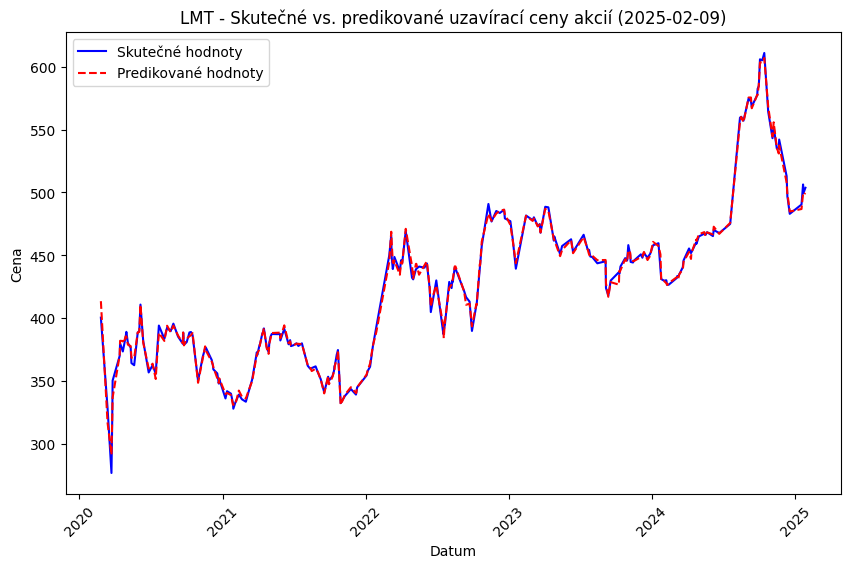

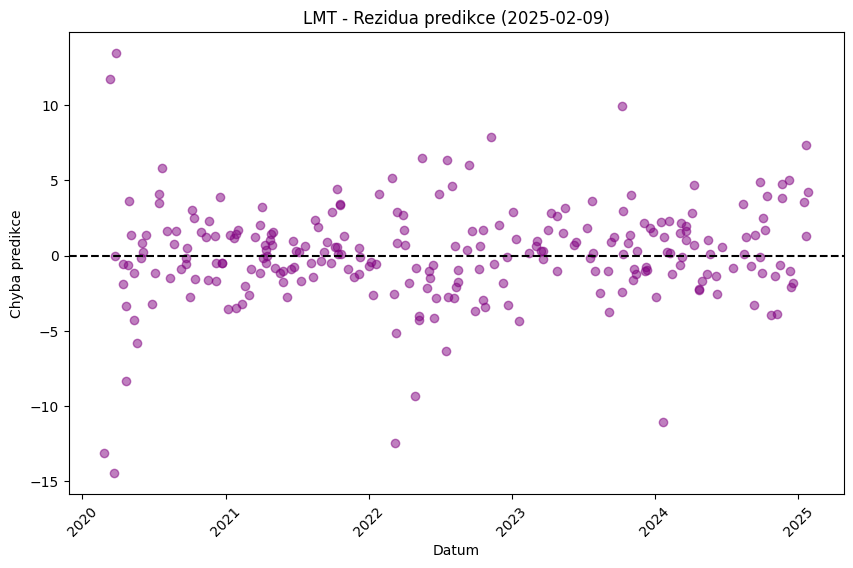

Zpracovávám akcii: AAPL
[*********************100%%**********************]  1 of 1 completed
AAPL - Mean Squared Error (MSE): 1.9876004854972928


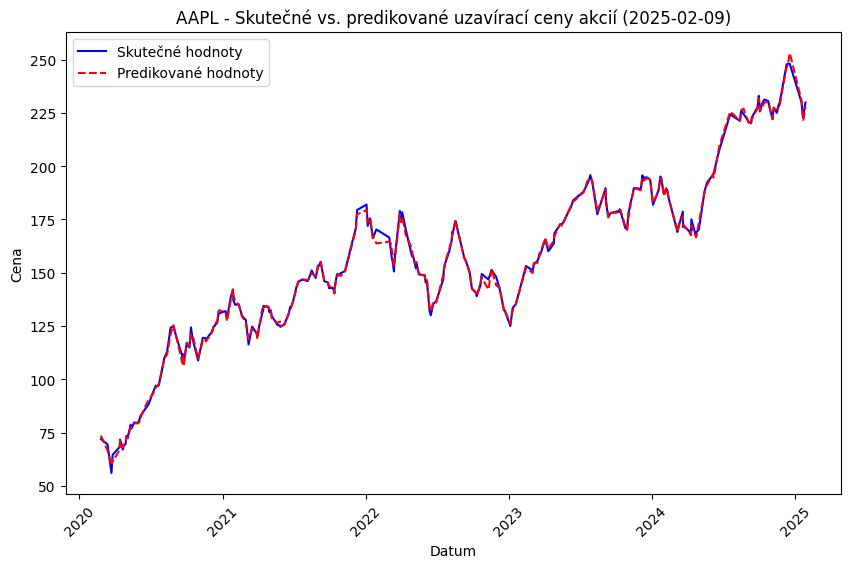

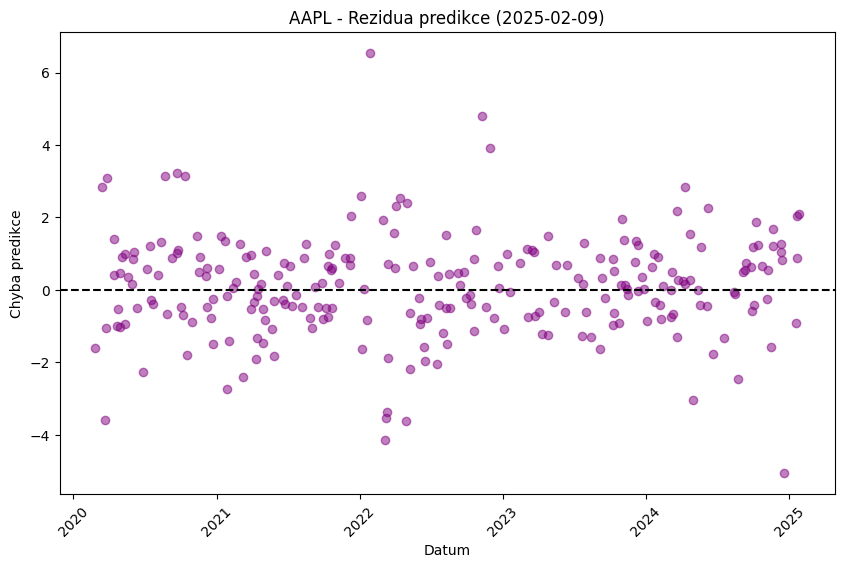

Zpracovávám akcii: MSFT
[*********************100%%**********************]  1 of 1 completed
MSFT - Mean Squared Error (MSE): 6.267038549700185


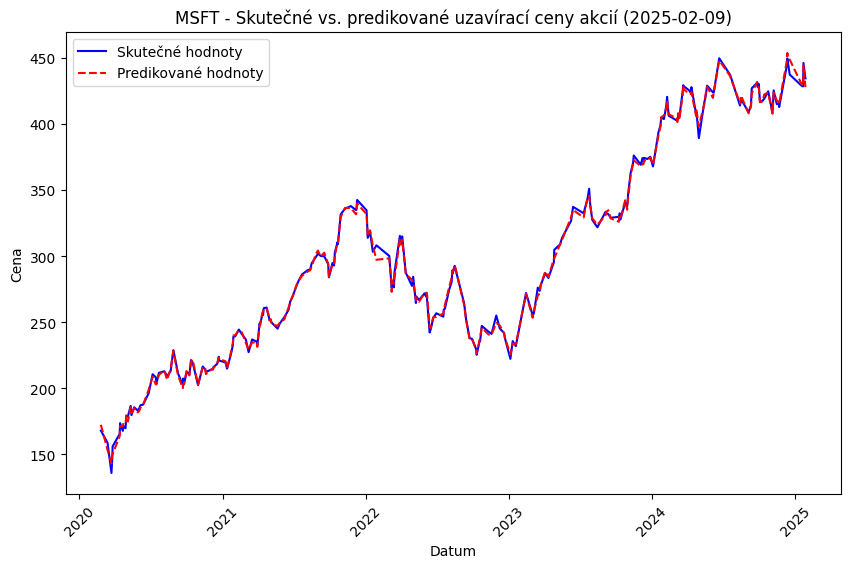

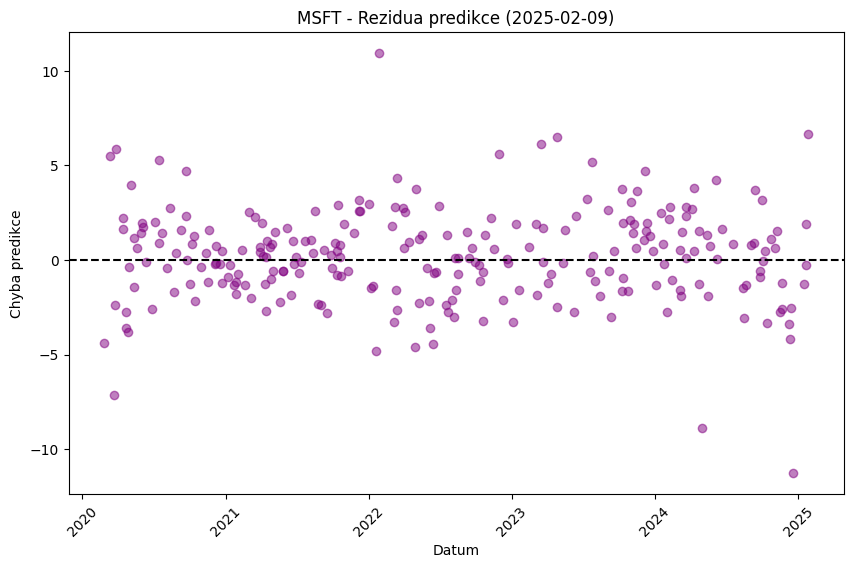

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime

# Aktuální datum
datum = datetime.now().strftime("%Y-%m-%d")

# Stažení dat
tickers = ["META", "TSLA", "LMT", "AAPL", "MSFT"]

for ticker in tickers:
    print(f"Zpracovávám akcii: {ticker}")
    df = yf.download(ticker, start="2020-02-08")
    df.reset_index(inplace=True)
    
    # Předzpracování dat pro model
    df['Date'] = pd.to_datetime(df['Date'])
    df['day_of_year'] = df['Date'].dt.dayofyear
    
    # Vstupní a cílové proměnné
    X = df[['Open', 'High', 'Low', 'Volume', 'day_of_year']]
    y = df['Close']
    
    # Rozdělení dat na trénovací a testovací sady
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Trénování modelu (Random Forest)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predikce
    y_pred = model.predict(X_test)
    
    # Vyhodnocení modelu
    mse = mean_squared_error(y_test, y_pred)
    print(f"{ticker} - Mean Squared Error (MSE): {mse}")
    
    # Seřazení testovacích dat podle data
    y_test_sorted = y_test.sort_index()
    y_pred_sorted = pd.Series(y_pred, index=y_test.index).sort_index()
    dates_sorted = df.loc[y_test_sorted.index, 'Date']
    
    # Vykreslení skutečných vs. predikovaných hodnot
    plt.figure(figsize=(10, 6))
    plt.plot(dates_sorted, y_test_sorted, label='Skutečné hodnoty', color='blue')
    plt.plot(dates_sorted, y_pred_sorted, label='Predikované hodnoty', color='red', linestyle='--')
    plt.title(f"{ticker} - Skutečné vs. predikované uzavírací ceny akcií ({datum})")
    plt.xlabel("Datum")
    plt.ylabel("Cena")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    
    # Vykreslení grafu reziduí (chyby predikce)
    residuals = y_test_sorted - y_pred_sorted
    plt.figure(figsize=(10, 6))
    plt.scatter(dates_sorted, residuals, color='purple', alpha=0.5)
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"{ticker} - Rezidua predikce ({datum})")
    plt.xlabel("Datum")
    plt.ylabel("Chyba predikce")
    plt.xticks(rotation=45)
    plt.show()



[*********************100%%**********************]  1 of 1 completed


c:\Users\Martin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0042
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.1681e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 5.4814e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.5493e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 5.8805e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.6287e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 5.5216e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 4.1197e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 4.5750e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 4.3614e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/st

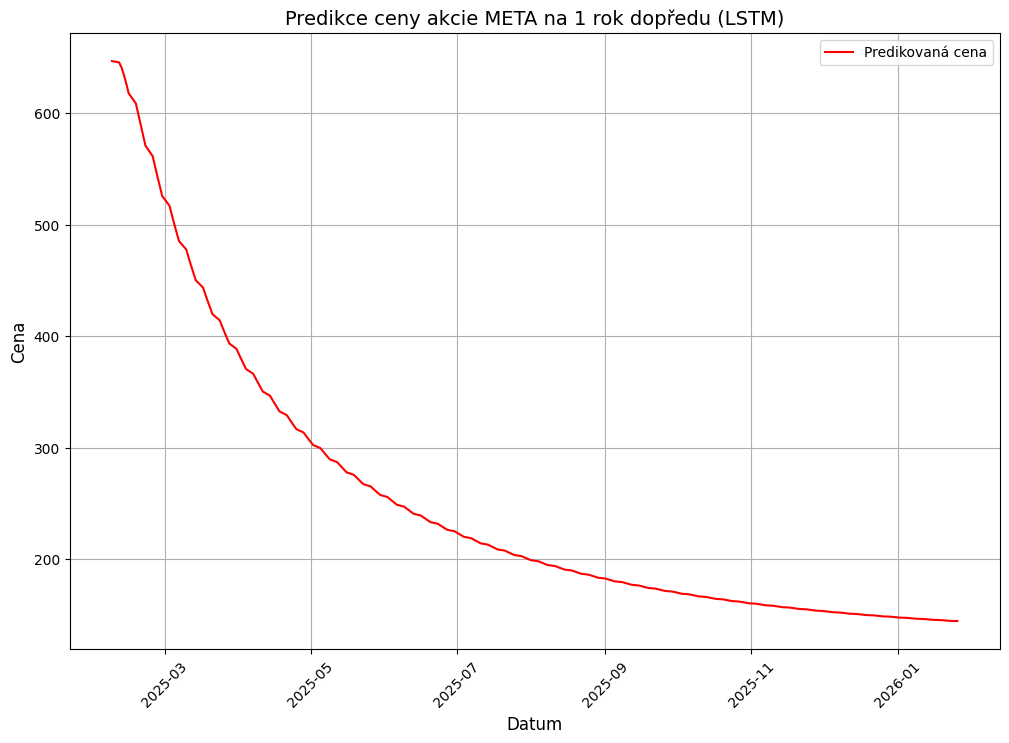

            Predicted Price
2025-02-07       646.609619
2025-02-10       645.421570
2025-02-11       640.880310
2025-02-12       634.258423
2025-02-13       626.361633


In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Stažení historických dat pro akcie (například META)
ticker = 'META'
df = yf.download(ticker, start="2015-01-01")

# Používáme pouze cenu Close
df = df[['Close']]

# Normalizace dat
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Funkce pro přípravu dat pro model LSTM
def prepare_data(df, window=60):
    X = []
    y = []
    
    # Vytvoření sekvencí pro trénink
    for i in range(window, len(df)):
        X.append(df[i-window:i, 0])  # Posledních 60 dní
        y.append(df[i, 0])  # Cílová hodnota (dnešní cena)
    
    X, y = np.array(X), np.array(y)
    return X, y

# Příprava dat pro trénování
X, y = prepare_data(scaled_data)

# Rozdělení na trénovací a testovací sady
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape pro LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Vytvoření modelu LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Výstupní vrstva pro predikci ceny

# Kompilace modelu
model.compile(optimizer='adam', loss='mean_squared_error')

# Trénování modelu
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predikce pro testovací data
y_pred = model.predict(X_test)

# Inverse transformace pro zpět na původní cenovou škálu
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

# Predikce na 1 rok dopředu (vytvoření predikce pro následující dny)
last_60_days = scaled_data[-60:]  # Posledních 60 dní pro predikci
predicted_prices = []

for _ in range(252):  # 252 pracovních dní za rok
    # Vytvoření nové predikce
    predicted_price = model.predict(last_60_days.reshape(1, 60, 1))
    predicted_prices.append(predicted_price[0, 0])
    
    # Přidání predikované hodnoty pro další predikci
    last_60_days = np.append(last_60_days[1:], predicted_price, axis=0)

# Inverse transformace pro zpět na původní cenovou škálu
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Vytvoření datového rámce pro zobrazení výsledků
predicted_dates = pd.date_range(df.index[-1], periods=252, freq='B')  # 252 pracovních dní za rok
predicted_df = pd.DataFrame(predicted_prices, index=predicted_dates, columns=["Predicted Price"])

# Graf predikovaných cen pro následující rok s datem
plt.figure(figsize=(12, 8))
plt.plot(predicted_df.index, predicted_df['Predicted Price'], color='red', label='Predikovaná cena')
plt.title(f'Predikce ceny akcie {ticker} na 1 rok dopředu (LSTM)', fontsize=14)
plt.xlabel('Datum', fontsize=12)
plt.ylabel('Cena', fontsize=12)
plt.legend()
plt.xticks(rotation=45)  # Rotace dat pro lepší čitelnost
plt.grid(True)
plt.show()

# Tisk datového rámce pro predikované ceny
print(predicted_df.head())  # Zobrazí první predikované ceny s datem




In [36]:
import pandas as pd
import yfinance as yf

# Stáhnout historická data pro META (můžete si přizpůsobit podle potřeby)
meta_data = yf.download("META", start="2020-01-01", end="2025-01-01")

# Vypočteme 50-denní SMA
meta_data['SMA_50'] = meta_data['Close'].rolling(window=50).mean()

# Připravíme signály pro nákup a prodej
meta_data['Signal'] = 0
meta_data.loc[meta_data['Close'] > meta_data['SMA_50'], 'Signal'] = 1  # Nákupní signál
meta_data.loc[meta_data['Close'] <= meta_data['SMA_50'], 'Signal'] = -1  # Prodejní signál

# Vypočteme denní návratnost
meta_data['Daily_Return'] = meta_data['Close'].pct_change() * meta_data['Signal'].shift(1)

# Celkový zisk z obchodní strategie
total_return = meta_data['Daily_Return'].sum()
print(f"Celkový zisk obchodní strategie: {total_return:.2%}")


[*********************100%%**********************]  1 of 1 completed
Celkový zisk obchodní strategie: 12.64%


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


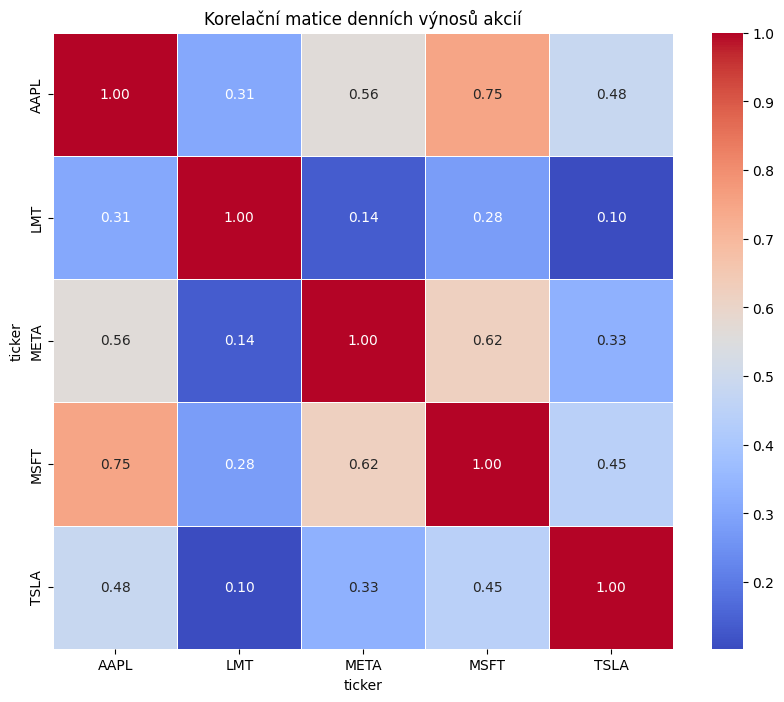

In [41]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tickers = ["META", "TSLA", "LMT", "AAPL", "MSFT"]
df_list = []

# Stáhnutí dat pro všechny tickery
for ticker in tickers:
    df = yf.download(ticker, start="2020-01-01", end="2025-01-01")
    df["ticker"] = ticker
    df_list.append(df)

# Spojení všech dat do jednoho DataFrame
df_all = pd.concat(df_list)
df_all.reset_index(inplace=True)

# Vytvoření denních výnosů pro každou akcii
df_all['Daily_Return'] = df_all.groupby('ticker')['Close'].pct_change()

# Korelace mezi denními výnosy jednotlivých akcií
df_pivot = df_all.pivot_table(index='Date', columns='ticker', values='Daily_Return')

# Vypočteme korelaci mezi jednotlivými akciemi
correlation_matrix = df_pivot.corr()

# Vykreslení korelační matice
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelační matice denních výnosů akcií")
plt.show()

[*********************100%%**********************]  1 of 1 completed


C:\Users\Martin\AppData\Local\Temp\ipykernel_11388\565096533.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['Signal'][meta_data['Close'] > meta_data['SMA_50']] = 1
C:\Users\Martin\AppData\Local\Temp\ipykernel_11388\565096533.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['Signal'][meta_data['Close'] <= meta_data['SMA_50']] = -1


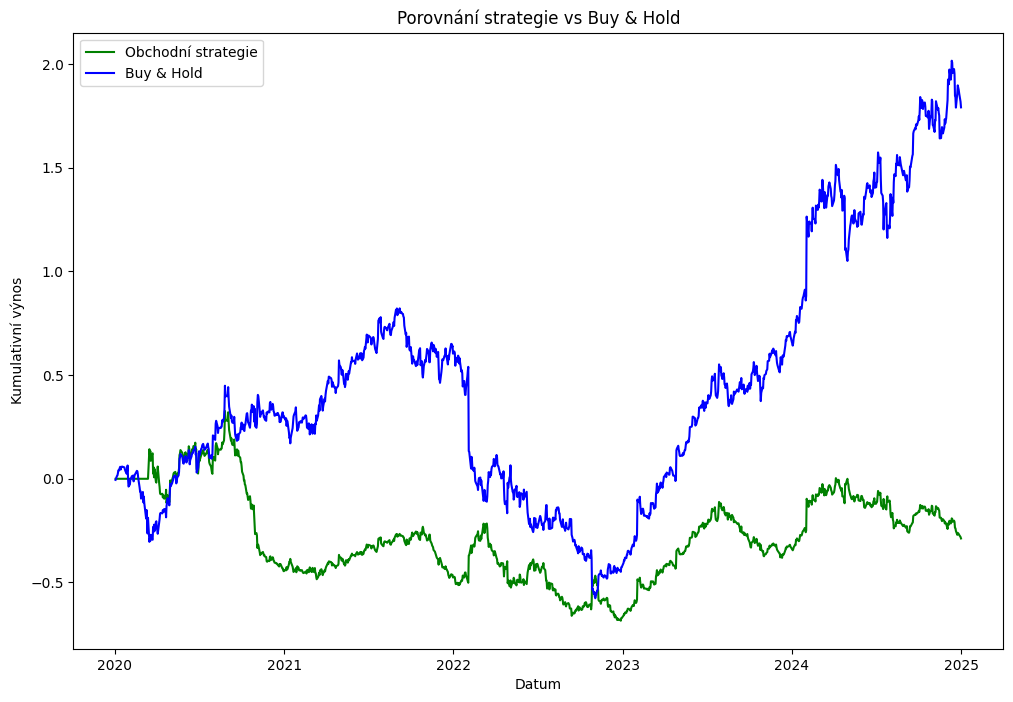

In [43]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Stažení historických dat pro akcii META
meta_data = yf.download("META", start="2020-01-01", end="2025-01-01")

# Vytvoření 50denní SMA (Simple Moving Average)
meta_data['SMA_50'] = meta_data['Close'].rolling(window=50).mean()

# Signály: Koupit, když cena je nad SMA, prodat, když je pod
meta_data['Signal'] = 0
meta_data['Signal'][meta_data['Close'] > meta_data['SMA_50']] = 1
meta_data['Signal'][meta_data['Close'] <= meta_data['SMA_50']] = -1

# Výpočet denních výnosů
meta_data['Daily_Return'] = meta_data['Close'].pct_change()

# Výpočet výnosů podle strategie
meta_data['Strategy_Return'] = meta_data['Daily_Return'] * meta_data['Signal'].shift(1)

# Kumulativní zisky strategie a Buy & Hold
meta_data['Cumulative_Strategy_Return'] = (1 + meta_data['Strategy_Return']).cumprod() - 1
meta_data['Cumulative_Buy_Hold_Return'] = (1 + meta_data['Daily_Return']).cumprod() - 1

# Graf vývoje kumulativních výnosů
plt.figure(figsize=(12, 8))
plt.plot(meta_data.index, meta_data['Cumulative_Strategy_Return'], label="Obchodní strategie", color='green')
plt.plot(meta_data.index, meta_data['Cumulative_Buy_Hold_Return'], label="Buy & Hold", color='blue')
plt.legend()
plt.title("Porovnání strategie vs Buy & Hold")
plt.xlabel("Datum")
plt.ylabel("Kumulativní výnos")
plt.show()

[*********************100%%**********************]  1 of 1 completed


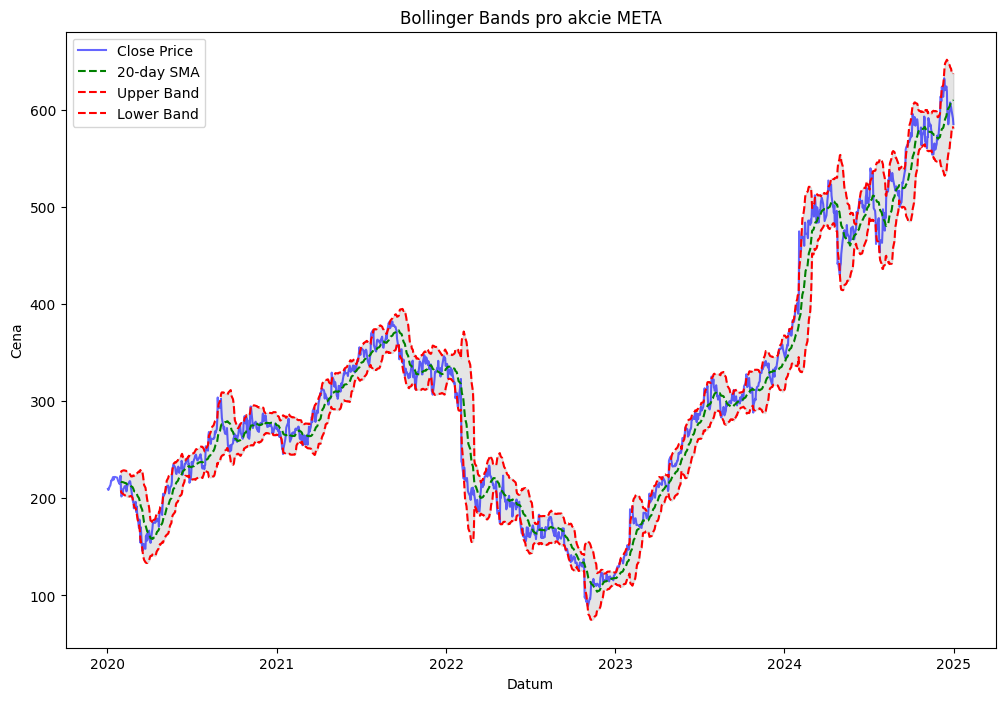

In [45]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Stažení historických dat pro akcie Meta (META)
meta_data = yf.download("META", start="2020-01-01", end="2025-01-01")

# Výpočet 20-denního klouzavého průměru (SMA) a standardní odchylky
meta_data['SMA_20'] = meta_data['Close'].rolling(window=20).mean()
meta_data['STD_20'] = meta_data['Close'].rolling(window=20).std()

# Vytvoření Bollingerových pásma
meta_data['Upper_Band'] = meta_data['SMA_20'] + (meta_data['STD_20'] * 2)
meta_data['Lower_Band'] = meta_data['SMA_20'] - (meta_data['STD_20'] * 2)

# Vykreslení grafu
plt.figure(figsize=(12, 8))
plt.plot(meta_data['Close'], label="Close Price", color='blue', alpha=0.6)
plt.plot(meta_data['SMA_20'], label="20-day SMA", color='green', linestyle='--')
plt.plot(meta_data['Upper_Band'], label="Upper Band", color='red', linestyle='--')
plt.plot(meta_data['Lower_Band'], label="Lower Band", color='red', linestyle='--')

# Grafické vylepšení
plt.fill_between(meta_data.index, meta_data['Upper_Band'], meta_data['Lower_Band'], color='grey', alpha=0.2)
plt.title("Bollinger Bands pro akcie META")
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.legend()
plt.show()
